<a href="https://www.kaggle.com/code/nikhil1e9/stock-price-forecasting-using-prophet?scriptVersionId=139865097" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MAANG companies Stock Price Forecasting using Prophet 

![](https://imgnew.outlookindia.com/uploadimage/library/16_9/16_9_5/._1650983624.jpg)

# 📥<span style="font-family:cursive; color:green;"> Loading the data </span>
***

In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sns.set_style('darkgrid')
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import files
daily_path, weekly_path, monthly_path  = [], [], []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.split('_')[1] == 'daily.csv':
            daily_path.append(os.path.join(dirname, filename))
        elif filename.split('_')[1] == 'weekly.csv':
            weekly_path.append(os.path.join(dirname, filename))
        else:
            monthly_path.append(os.path.join(dirname, filename))
monthly_path

['/kaggle/input/netflix-stock-price/APPLE_monthly.csv',
 '/kaggle/input/netflix-stock-price/NETFLIX_monthly.csv',
 '/kaggle/input/netflix-stock-price/META_monthly.csv',
 '/kaggle/input/netflix-stock-price/AMAZON_monthly.csv',
 '/kaggle/input/netflix-stock-price/GOOGLE_monthly.csv']

I will be analyzing the weekly data in this notebook

In [3]:
# Read files to pandas dataframe
aapl_monthly, nflx_monthly, meta_monthly, amzn_monthly, goog_monthly = [pd.read_csv(file) 
                                                                        for file in monthly_path]
nflx_monthly.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
251,2023-05-01,329.440002,405.109985,315.619995,395.230011,395.230011,145471700
252,2023-06-01,397.410004,448.649994,393.079987,440.489990,440.489990,147230800
253,2023-07-01,439.760010,485.000000,411.880005,438.970001,438.970001,168720200
254,2023-08-01,437.369995,445.250000,421.329987,421.660004,421.660004,44095200
255,2023-08-11,428.980011,430.626495,421.327698,421.660004,421.660004,3927914


# 💪<span style="font-family:cursive; color:green;"> Domain knowledge </span>

***

Before we start analyzing our data it is always a good practice to get a clear understanding of the data by looking at what all the features mean. This greatly helps in structuring a solution to the problem and makes it easier to extract meaningful insights from the data.

Let's take a look at all the features

- **Open**: Opening price of the stock on a given date
- **High**: Highest price of the stock on a given date
- **Low**: Lowest price of the stock on a given date
- **Close**: Closing price of the stock on a given date
- **Adj Close**: Adjusted closing price of the stock on a given date
- **Volume**: Total number of shares traded on a given date

Let's go into a bit more detail and study each of the terms with a more domain specific knowledge.

> **Open** means the price at which a stock started trading as soon as the market opens. This value can be the same as where the stock closed the night before, but not always. Sometimes events such as company earning reports after trading hours can alter a stock’s price overnight.

> Then comes “close”. **Close** refers to the price of an individual stock when the stock exchange closes for the day. It represents the last buy-sell order executed between two traders. This usually occurs in the final seconds of the trading day.

> There is not much to say about the **High** and **Low**. The high is the highest price at which a stock is traded during a period. The low is the lowest price of the period. These give us an idea of the stock’s trading range weekly, monthly, annually etc.

> The **Adjusted Close** requires a deep knowledge of how the stock market and the company dynamics function at large. To put it simply, it factors in the impact of dividends, stock splits, and other corporate events that can distort the raw closing price.

> **Volume** is the total number of shares traded in a specific period. Every time buyers and sellers exchange shares, the amount gets added to the period’s total volume. 

Of all the features above the most important are **Close** and **Volume**

- The **Close price** is considered the reference point for any time frame. When researching historical stock price data, financial institutions, regulators, and individual investors use the closing price as the standard measure of the stock’s value.

- Studying **Volume** patterns are an essential aspect of technical analysis because it can show the significance of a stock’s price movement. For example, a price change that occurs in high volume can carry more weight because it indicates that many traders were behind the move. Conversely, a lower volume price move can be perceived as less critical.

<div class="alert alert-block alert-info"> 📌 <b>Note:</b> 

# 🔎<span style="color:green; font-family:cursive;">Analyzing the data</span>
***

Now let's begin analyzing our data

In [4]:
nflx_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       256 non-null    object 
 1   Open       256 non-null    float64
 2   High       256 non-null    float64
 3   Low        256 non-null    float64
 4   Close      256 non-null    float64
 5   Adj Close  256 non-null    float64
 6   Volume     256 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.1+ KB


In [5]:
nflx_monthly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There is no missing data

In [6]:
nflx_monthly.describe(include='all')

,Date,Open,High,Low,Close,Adj Close,Volume
count,256,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02
unique,256,NaN,NaN,NaN,NaN,NaN,NaN
top,2002-06-01,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,128.542031,140.728752,117.726545,129.914403,129.914403,3.355288e+08
std,NaN,172.287470,186.237696,158.767450,172.638131,172.638131,2.777798e+08
min,NaN,0.628571,0.735714,0.346429,0.640714,0.640714,3.927914e+06
25%,NaN,4.132857,4.638928,3.691071,4.172500,4.172500,1.579664e+08
50%,NaN,32.970001,35.987856,29.269285,33.405714,33.405714,2.495357e+08
75%,NaN,221.315002,260.695004,199.497498,227.534996,227.534996,4.104317e+08


observation: Minimum closing price of Netflix's stock was 0.64 USD and the maximum has come upto 690 USD. That's an increase of more than 1000 times in 21 years of the stock's history.

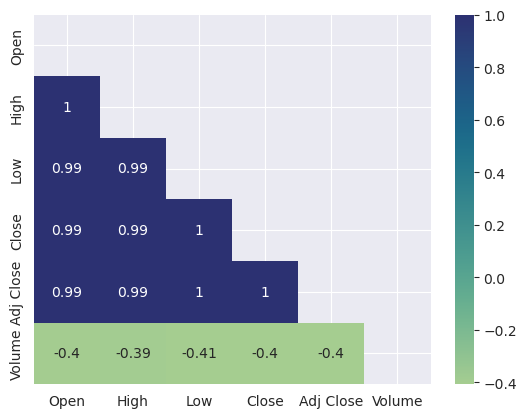

In [7]:
mask = np.triu(np.ones_like(nflx_monthly.corr(numeric_only=True))).astype(bool)
sns.heatmap(nflx_monthly.corr(numeric_only=True), annot=True, mask=mask, cmap='crest')
plt.show()

Most of the features are highly correlated. This is because stock prices on a given date doesn't vary much except for some rare events or in case of highly volatile stocks such as in crypto.

# 📉 <span style="color:green; font-family:cursive;">Visualizing historical performance of stocks</span>
***

In [8]:
px.area(nflx_monthly, x='Date', y='Close')

The highest ever price of a single Netflix stock was \\$690 and was recorded in October of 2021. I looked it up and found that Netflix began its streaming service in January 2007. According to the plot the price was `$`3.25 back then and it is close to `$`429 in August 2023. That's an increase of 131 times. This means if a person would have invested a `$`1000 in 2007 it would have become a whopping $131,000 by now 🤑.

In [9]:
px.bar(nflx_monthly, y='Volume', x='Date')

This shows that most trades occured in Sep 2011, Oct 2011 and Jan 2012 with as high as 1.8 billion trades in a single month.

In [10]:
px.box(nflx_monthly, y='Close')

## Stock prices comparison

In [11]:
stocks_dict = {'APPLE': aapl_monthly, 
               'NETFLIX': nflx_monthly, 
               'META': meta_monthly, 
               'AMAZON': amzn_monthly, 
               'GOOGLE': goog_monthly}

In [12]:
# Comparing stock prices for all companies
fig = go.Figure()
for name, df in stocks_dict.items():
    df_filtered = df[df['Date']>='2009-01-01']
    fig.add_trace(go.Scatter(x=df_filtered['Date'], 
                             y=df_filtered['Close'], 
                             name=name))
fig.show()

It can be seen that at the start of 2020 stock prices started going high due to COVID. Netflix stocks went an all time high in 2020-21 due to obvious reasons.

It can also be seen that stock prices started plummeting near the end of 2021 and start of 2022. Netflix's stock prices crashed and came down to the lowest in 4 years.

In [13]:
# Comparing volume for all companies
fig = go.Figure()
for name, df in stocks_dict.items():
    df_filtered = df[df['Date']>='2004-01-01']
    fig.add_trace(go.Scatter(x=df_filtered['Date'], 
                             y=df_filtered['Volume'], 
                             name=name))
fig.show()

Apple has the highest volume of stocks traded all time out of the five companies. Also the volume seems to go down with time. 

 # 🔮<span style="color:green; font-family:cursive;">Stock price forecasting</span>
***
Now we come to the main and most interesting task, forecasting the stock prices. I will use Facebook's [Prophet](https://facebook.github.io/prophet/) library for the task of stock price forecasting. Some advantages of Prophet are listed below:

## Advantages of Prophet

- **Accurate and Fast**: It is accurate and can generate results a lot faster compared to other time series libraries.
- **Reliable**: It can accommodate strong seasonal effects in the data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- **Domain Knowledge integration**: Forecasting can be made better by adding domain knowledge expertise like holidays and patterns.
- **Available in R or Python**: It can be implemented both in Python and R and has extensive documentation available for both.

In [14]:
# Install and import Prophet
# !pip install prophet
from prophet import Prophet

**Prophet** takes a dataframe as input with only 2 columns - **ds and y**. The ds (datestamp) column should be in a specific format, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp to be parsed by Prophet. The y column must be numeric, and represents the variable we wish to forecast. Therefore we must rename the columns before proceeding further

In [15]:
# Convert dates to datetime format
nflx_monthly.Date = pd.to_datetime(nflx_monthly.Date)
nflx_monthly.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [16]:
# Change column names to ds and y
prophet_df = nflx_monthly[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df.head()

,ds,y
0,2002-06-01,0.999286
1,2002-07-01,0.953571
2,2002-08-01,0.936429
3,2002-09-01,0.692857
4,2002-10-01,0.640714


In [17]:
# Fit the model to the data
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

08:28:06 - cmdstanpy - INFO - Chain [1] start processing
08:28:06 - cmdstanpy - INFO - Chain [1] done processing


The model is all set to go and make predictions for the future. To predict the stock prices for future dates Prophet provides the `make_future_dataframe` function. This make things easier and save a lot of time and effort.

In [18]:
# Make future predictions 1 year ahead
future_dates = model.make_future_dataframe(periods=12, freq='MS')
# future_dates.tail(13)
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-06-01,-2.356884,-103.396084,73.067936,-2.356884,-2.356884,-13.090754,-13.090754,-13.090754,-13.449337,-13.449337,-13.449337,0.358583,0.358583,0.358583,0.0,0.0,0.0,-15.447638
1,2002-07-01,-1.992378,-98.293180,68.032833,-1.992378,-1.992378,-13.985709,-13.985709,-13.985709,-13.449337,-13.449337,-13.449337,-0.536371,-0.536371,-0.536371,0.0,0.0,0.0,-15.978087
2,2002-08-01,-1.615721,-99.612582,69.742017,-1.615721,-1.615721,-11.779312,-11.779312,-11.779312,-13.449337,-13.449337,-13.449337,1.670025,1.670025,1.670025,0.0,0.0,0.0,-13.395033
3,2002-09-01,-1.239065,-94.842916,74.342936,-1.239065,-1.239065,-12.585161,-12.585161,-12.585161,-13.449337,-13.449337,-13.449337,0.864177,0.864177,0.864177,0.0,0.0,0.0,-13.824226
4,2002-10-01,-0.874559,-98.910163,75.999268,-0.874559,-0.874559,-9.076577,-9.076577,-9.076577,-13.449337,-13.449337,-13.449337,4.372760,4.372760,4.372760,0.0,0.0,0.0,-9.951136


Prophet generates a dataframe with many columns. Most of the columns generated account for the seasonality and trends in the data which prophet detects automatically. We will not need most of these columns. 

The most relevant columns are **ds** which represents datestamp, **yhat** which indicate the forecasted values, **yhat_lower** and **yhat_upper** which indicate the lower and upper bound for the predicted values. Let's have a look at these separately.

In [19]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2002-06-01,-103.396084,73.067936,-15.447638
1,2002-07-01,-98.293180,68.032833,-15.978087
2,2002-08-01,-99.612582,69.742017,-13.395033
3,2002-09-01,-94.842916,74.342936,-13.824226
4,2002-10-01,-98.910163,75.999268,-9.951136
...,...,...,...,...
263,2024-04-01,422.976137,589.394945,508.094541
264,2024-05-01,424.913116,604.034088,514.047343
265,2024-06-01,435.013454,606.732363,520.285821
266,2024-07-01,433.231241,612.309987,524.228197


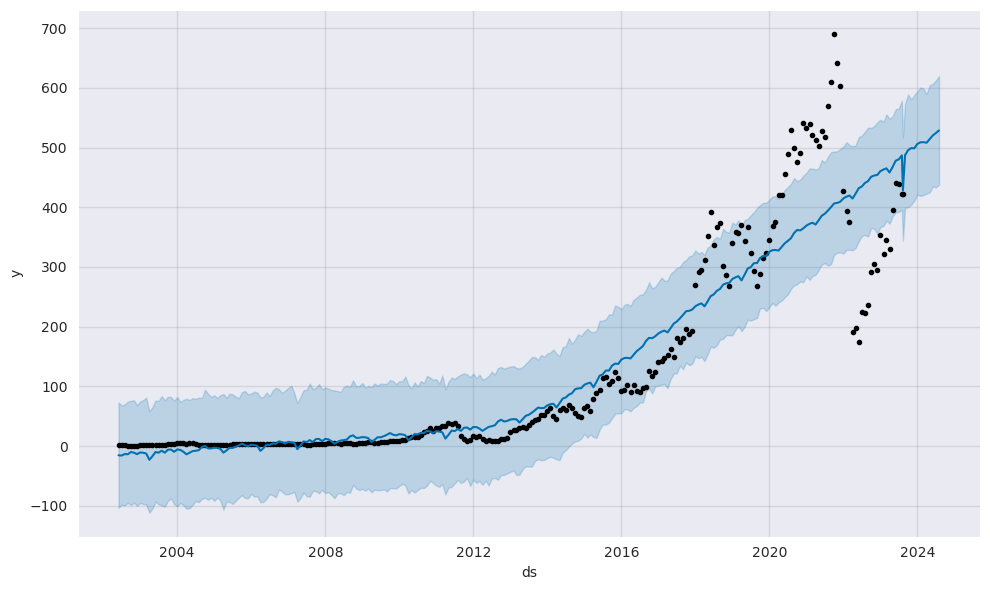

In [20]:
# Plot forecasted values along with observed values
fig = model.plot(forecast)
fig.show()

Prophet plots the original stock prices (black dots), the forecasted prices (blue line) and the uncertainty intervals of the forecasts (the blue shaded regions). This interval marks the model's confidence in its predictions. When the shaded region is wide it means the model is not much confident in its prediction and when it is narrow the model is quite confident.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

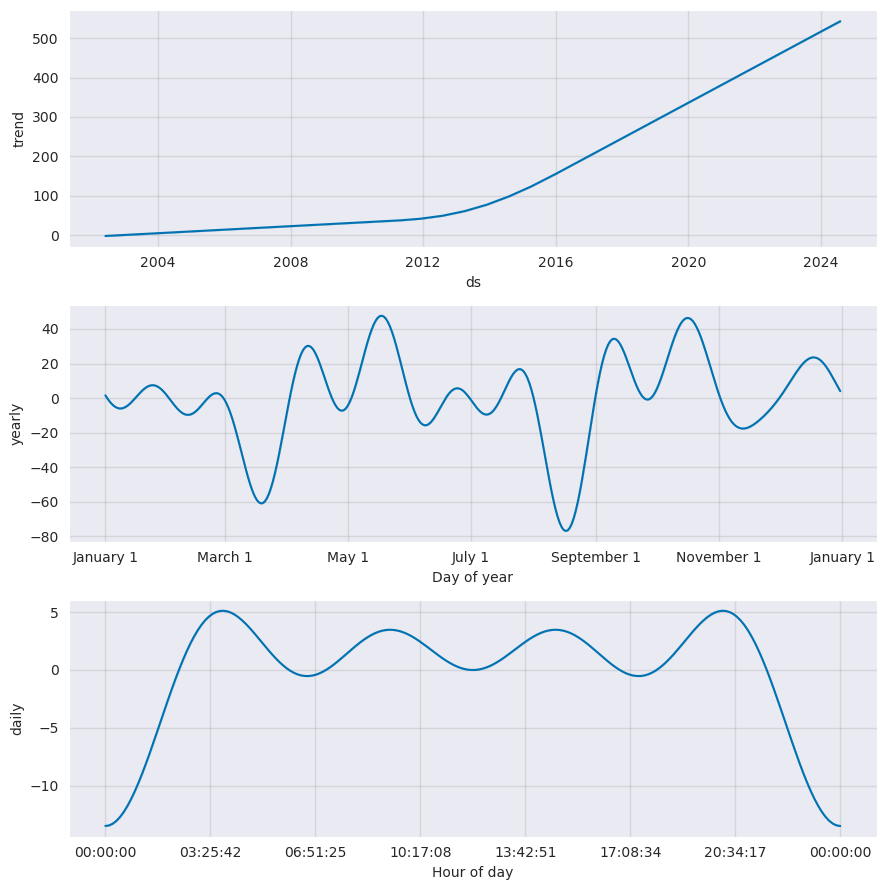

In [21]:
# Plot components extracted from forecasts
fig = model.plot_components(forecast)
fig.show()

The above plots provide interesting insights into how the forecasting is done breaking down each individual component. 
- The first plot shows the overall trend of the stock price. According to the plot, the price started increasing rapidly after 2013.
- The second shows yearly trend of the forecasted model. It shows Netflix's stock prices peak in April and June.
- The third one shows the daily trends of the prices. It indicates how the price fluctuates depending on the time of day.

## Forecasting for each company

08:28:10 - cmdstanpy - INFO - Chain [1] start processing
08:28:10 - cmdstanpy - INFO - Chain [1] done processing
08:28:11 - cmdstanpy - INFO - Chain [1] start processing
08:28:11 - cmdstanpy - INFO - Chain [1] done processing
08:28:12 - cmdstanpy - INFO - Chain [1] start processing
08:28:12 - cmdstanpy - INFO - Chain [1] done processing
08:28:13 - cmdstanpy - INFO - Chain [1] start processing
08:28:13 - cmdstanpy - INFO - Chain [1] done processing
08:28:14 - cmdstanpy - INFO - Chain [1] start processing
08:28:14 - cmdstanpy - INFO - Chain [1] done processing


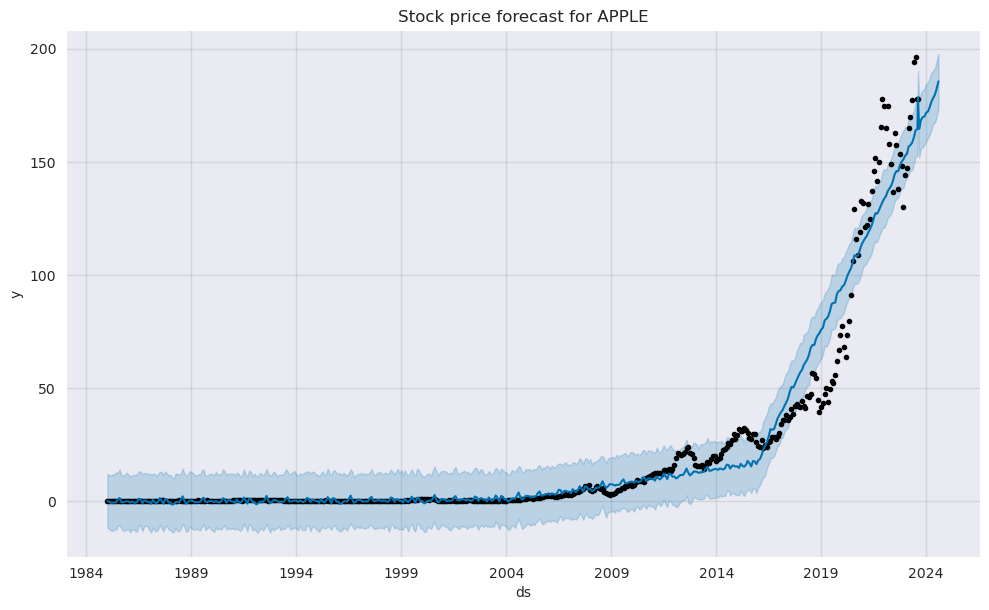

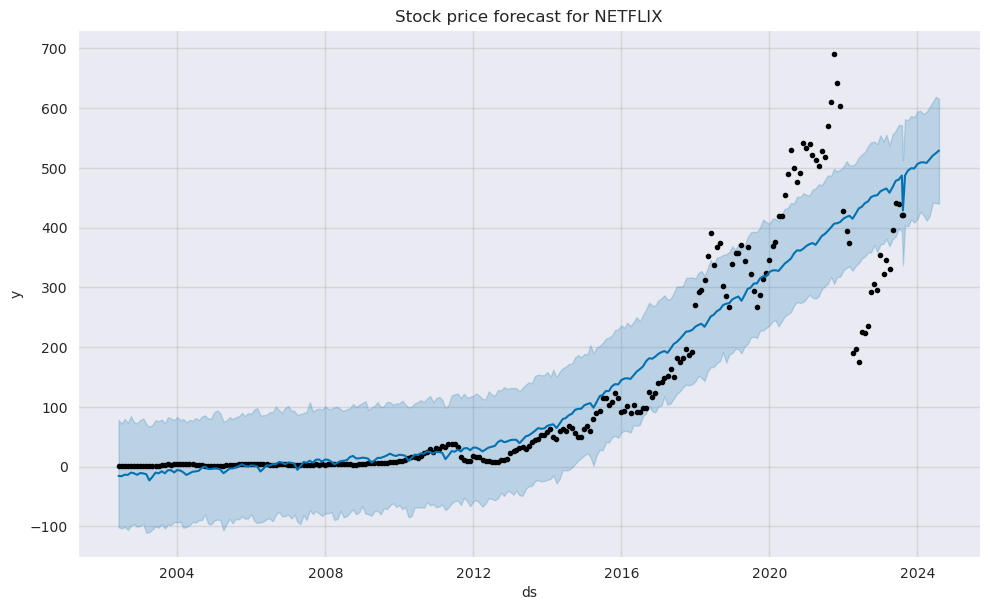

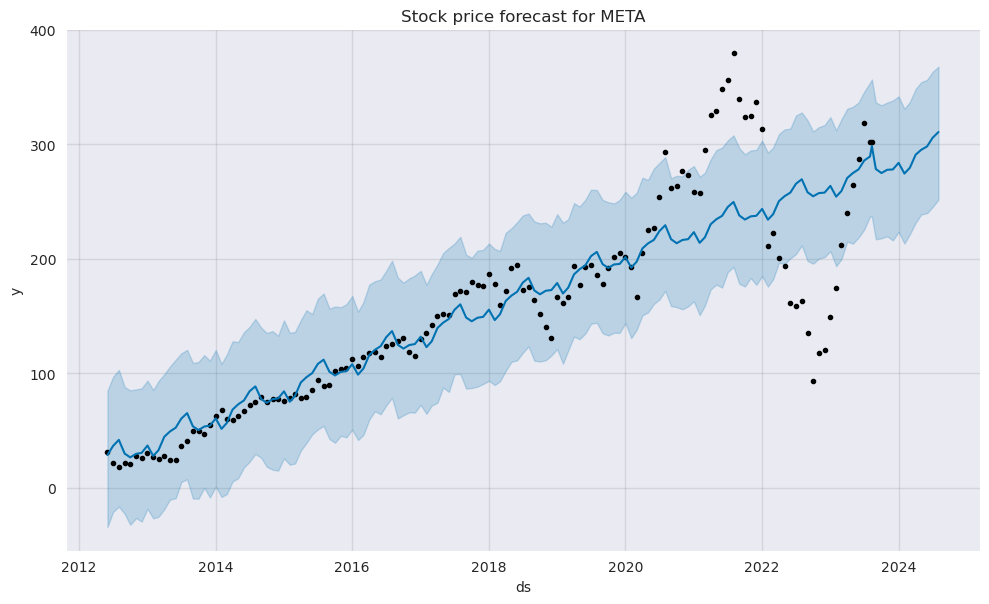

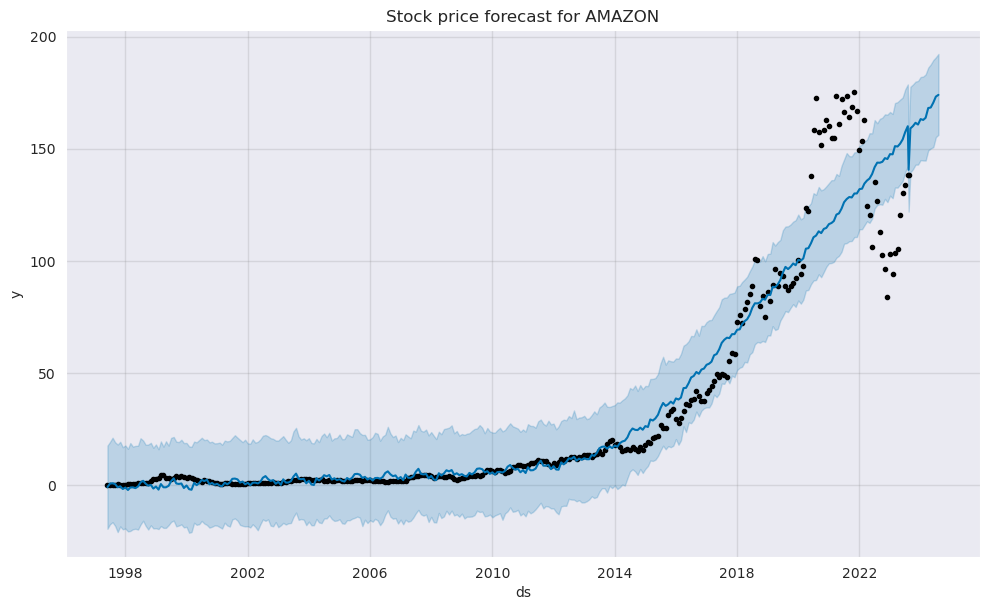

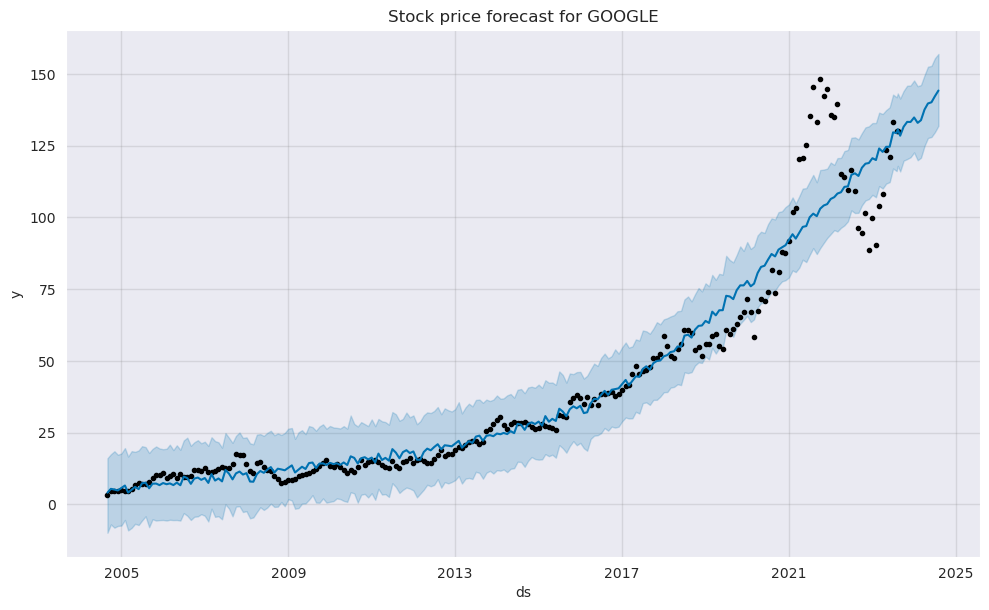

In [22]:
for name, df in stocks_dict.items():
    df.Date = pd.to_datetime(df.Date)
    prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)
    future_df = model.make_future_dataframe(periods=12, freq='MS')
    
    forecast = model.predict(future_df)
    fig = model.plot(forecast)
    plt.title(f"Stock price forecast for {name}")
    fig.show()

# 📕<span style="color:green; font-family:cursive;">Summary</span>
***

In this notebook we looked at the historical stock prices of MAANG companies and how they varied over time. The analysis was done for monthly stock prices for each stock. The stock prices were then forecasted using Prophet for upto 1 year into the future. 



***Thanks, for sticking till the end. I hope you found this notebook interesting and valuable.***